In [ ]:
# !unzip '/content/drive/MyDrive/datasets/celeba-batches/batch2.zip' -d '/content/drive/MyDrive/datasets/celeba-batches/batch2'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import os
import time

In [ ]:
os.chdir('/content/drive/MyDrive/datasets/models/c9v1-batch-1-2')

In [ ]:
def load_data():
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        '/content/drive/MyDrive/datasets/celeba-batches/batch2', 
        label_mode=None, image_size=(64, 64), batch_size=32,
    )
    return dataset
dataset = load_data()
dataset = dataset.map(lambda x: x / 255.0)

Found 20000 files belonging to 1 classes.


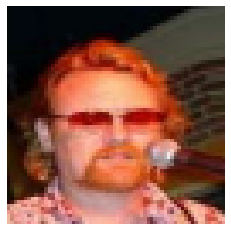

In [ ]:
for x in dataset.take(5):
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[2])
    break

In [ ]:
def create_generator():
    model = tf.keras.Sequential()
    
    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(8*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(8*8*4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 4)))

    model.add(layers.Conv2DTranspose(32, 3, strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(96, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


In [ ]:
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6400      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               16384     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0

In [ ]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3], activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 5, strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 5, strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 5, strides=(2, 2), padding='same', activation='relu'))
    # model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))

    return model

In [ ]:
d=create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          102464    
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)        

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_of_generated_examples = 32

seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [ ]:
# generator = create_generator()
# discriminator = create_discriminator()

generator = tf.keras.models.load_model('/content/drive/MyDrive/datasets/models/c9v1/c9v1-g-epoch20.h5')
discriminator = tf.keras.models.load_model('/content/drive/MyDrive/datasets/models/c9v1/c9v1-d-epoch20.h5')

@tf.function
def train_step(images):
    noise = tf.random.normal([32, noise_dim])

    global generator, discriminator
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
from tqdm import tqdm

def train_GAN(dataset, epochs):
  for epoch in range(epochs):
    print('starting epoch ', epoch)
    for image_batch in tqdm(dataset):
      train_step(image_batch)

    # noise= np.random.normal(loc=0, scale=1, size=[examples, 64])
    noise = tf.random.normal([100, noise_dim])
    generated_images = generator.predict(noise)
    # generated_images = generated_images.reshape(100,28,28)
    dim=(10,10)
    figsize=(10,10)
    plt.figure(figsize=figsize)
    # plt.figure()
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i].reshape(64, 64, 3), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image '+ str(epoch+20) + '.png')

In [ ]:
train_GAN(dataset, 20)

In [ ]:
generator.save('c9v1-batch-1-2-g-epoch20.h5')

In [ ]:
discriminator.save('c9v1-batch-1-2-d-epoch20.h5')